In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import timesynth as ts # package for generating time series

import matplotlib.pyplot as plt

from qolmat.utils import plot
from qolmat.imputations.rpca.pcp_rpca import PcpRPCA
from qolmat.imputations.rpca.temporal_rpca import TemporalRPCA, OnlineTemporalRPCA

**Generate synthetic data**

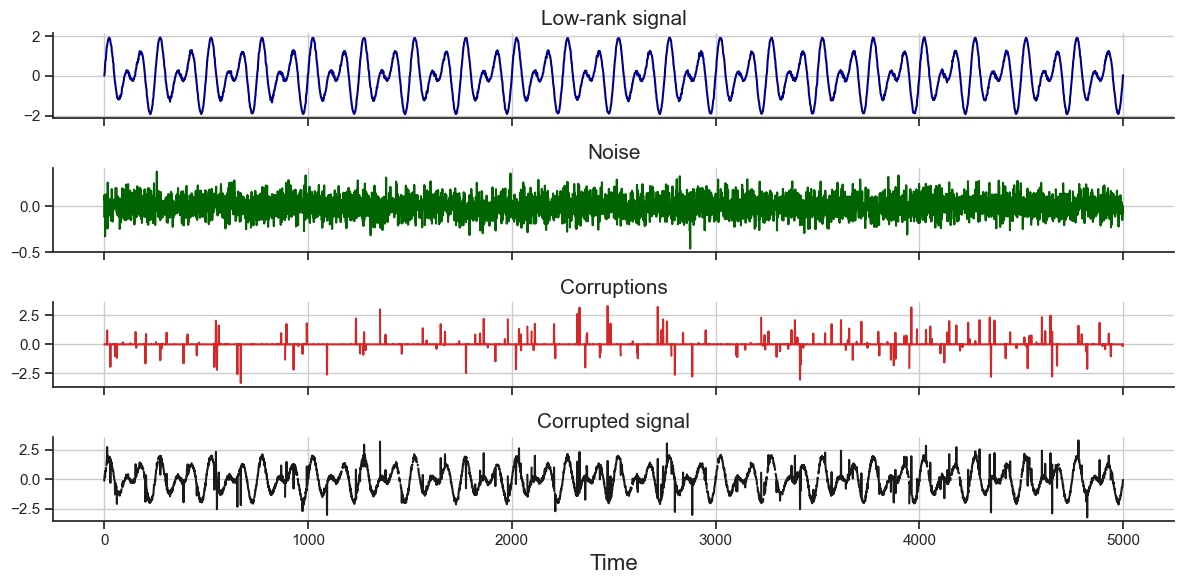

In [2]:
np.random.seed(402)

################################################################################

time_sampler = ts.TimeSampler(stop_time=20)
irregular_time_samples = time_sampler.sample_irregular_time(num_points=5_000, keep_percentage=100)
sinusoid = ts.signals.Sinusoidal(frequency=2)
white_noise = ts.noise.GaussianNoise(std=0.1)
timeseries = ts.TimeSeries(sinusoid, noise_generator=white_noise)
samples, signals, errors = timeseries.sample(irregular_time_samples)

n = len(samples)
pc = 0.02
indices_ano1 = np.random.choice(n, int(n*pc))
samples[indices_ano1] = [np.random.uniform(low=2*np.min(samples), high=2*np.max(samples)) for i in range(int(n*pc))]
indices = np.random.choice(n, int(n*pc))
samples[indices] = np.nan


################################################################################

time_sampler = ts.TimeSampler(stop_time=20)
irregular_time_samples = time_sampler.sample_irregular_time(num_points=5_000, keep_percentage=100)
sinusoid = ts.signals.Sinusoidal(frequency=3)
white_noise = ts.noise.GaussianNoise(std=0)
timeseries = ts.TimeSeries(sinusoid, noise_generator=white_noise)
samples2, signals2, errors2 = timeseries.sample(irregular_time_samples)

n2 = len(samples2)
indices_ano2 = np.random.choice(n2, int(n*pc))
samples2[indices_ano2] = [np.random.uniform(low=2*np.min(samples2), high=2*np.max(samples2)) for i in range(int(n2*pc))]
indices = np.random.choice(n2, int(n*pc))
samples2[indices] = np.nan

samples += samples2
signals += signals2
errors += errors2

################################################################################

fig, ax = plt.subplots(4, 1, sharex=True, figsize=(12,6))
ax[0].plot(range(n), signals, c="darkblue")
ax[0].set_title("Low-rank signal", fontsize=15)
ax[1].plot(range(n), errors, c="darkgreen")
ax[1].set_title("Noise", fontsize=15)
ax[2].plot(range(n), samples-signals-errors, c="tab:red")
ax[2].set_title("Corruptions", fontsize=15)
ax[3].plot(range(n), samples, c="k")
ax[3].set_title("Corrupted signal", fontsize=15)
ax[3].set_xlabel("Time", fontsize=16)
plt.tight_layout()
plt.show()

**RPCA**

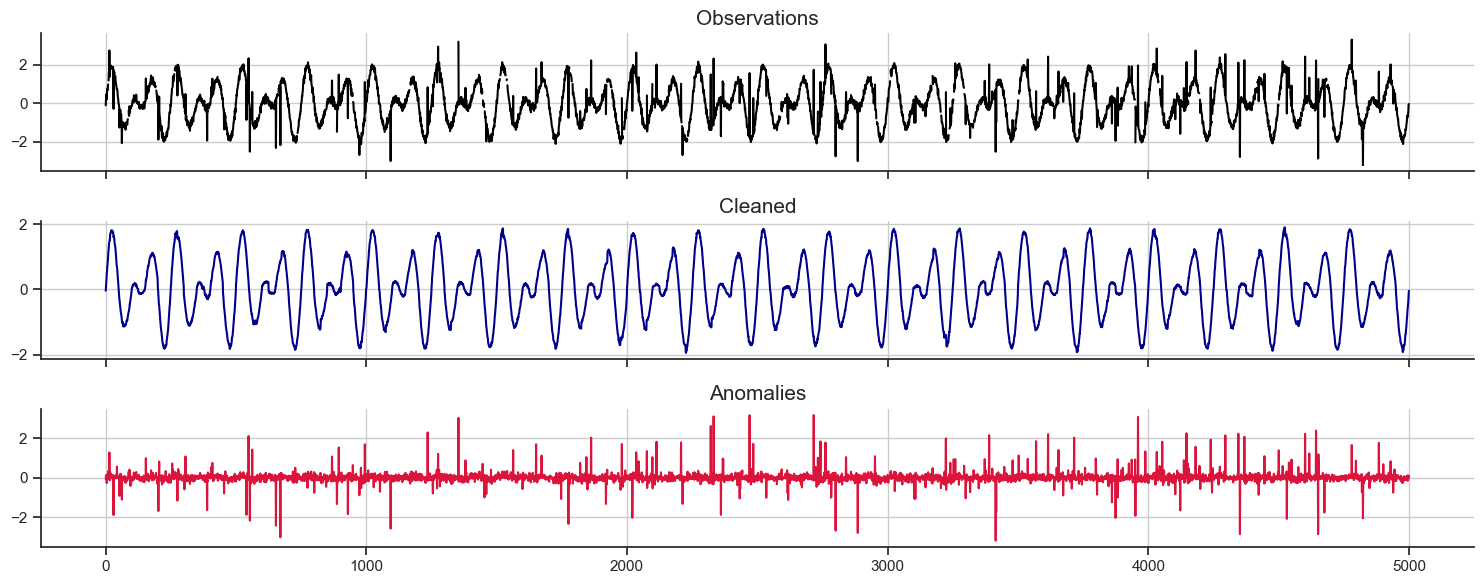

CPU times: user 1.29 s, sys: 275 ms, total: 1.56 s
Wall time: 553 ms


In [3]:
%%time

pcp_rpca = PcpRPCA(n_rows=25)
X, A, errors = pcp_rpca.fit_transform(X=samples)
plot.plot_signal([samples, X, A])

[0.33449884 0.48689258 0.52287156 0.55634615 0.58825948 0.61815654
 0.64566123 0.67273683 0.69925468 0.72397416 0.74847748 0.77203833
 0.7943113  0.81618081 0.83769745 0.8583494  0.87741084 0.89600206
 0.91314064 0.93009077 0.9466165  0.96164213 0.97549661 0.98849961
 1.        ]


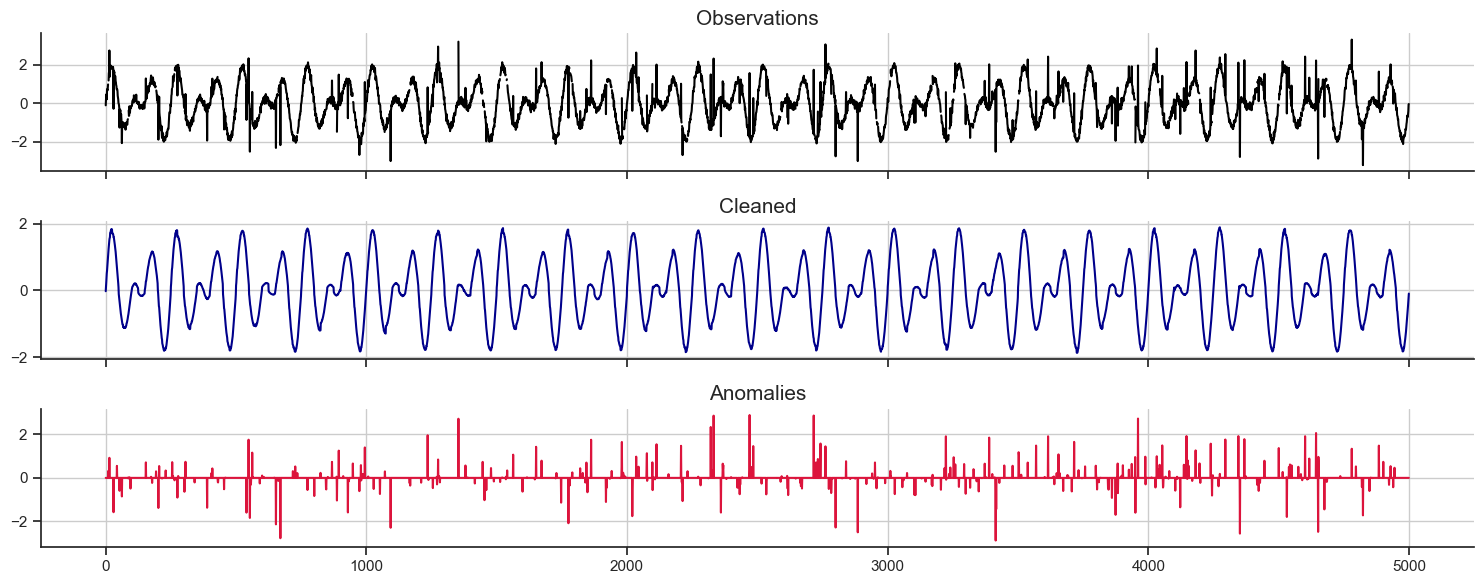

In [4]:
temporal_rpca = TemporalRPCA(n_rows=25, tau=2, lam=0.3, list_periods=[20], list_etas=[0.01], norm="L2")
X, A, errors =  temporal_rpca.fit_transform(X=samples)
plot.plot_signal([samples, X, A])

In [12]:
online_temp_rpca = OnlineTemporalRPCA(n_rows=25, tau=1, lam=0.3, list_periods=[20], list_etas=[0.01],
                       burnin=0.2, online_list_etas=[.3])
X, A = online_temp_rpca.fit_transform(X=samples)
plot.plot_signal([samples, X, A])

(25, 40)
BBB
[0.51384746 0.74068854 0.80368076 0.86519509 0.91848987 0.95639281
 0.98287563 1.        ]
BBB
[1.]


In [19]:
online_temp_rpca = OnlineTemporalRPCA(n_rows=25, tau=1, lam=0.3, list_periods=[20], list_etas=[0.01],
                       burnin=0.2, online_list_etas=[0.3], nwin=20)
X, A = online_temp_rpca.fit_transform(X=samples)
plot.plot_signal([samples, X, A], style="matplotlib")

(25, 40)
[0.51384746 0.74068854 0.80368076 0.86519509 0.91848987 0.95639281
 0.98287563 1.        ]


In [ ]:
len(samples)

5000